<a href="https://colab.research.google.com/github/rebcervasio/Machine_Learning_Materials_Science_PhD/blob/main/Machine_Learning_Ferroelectric_Perovskites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  High-thoughput ab initio calculation using Python



---------------------------------

### Used libraries

In [ ]:
!pip install pymatgen  # open-source librarie for materials analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 98 kB 6.9 MB/s 
     |████████████████████████████████| 515 kB 63.3 MB/s 
     |████████████████████████████████| 109 kB 57.7 MB/s 
     |████████████████████████████████| 70 kB 8.4 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 
     |████████████████████████████████| 561 kB 73.2 MB/s 
     |████████████████████████████████| 235 kB 50.7 MB/s 
     |████████████████████████████████| 555 kB 49.7 MB/s 
  Created wheel for pymatgen: filename=pymatgen-2022.11.7-cp38-cp38-linux_x86_64.whl size=3904361 sha256=230fc1b3b58cd3bee952efb2a78dcf3c115e82318677fdd0b87c79004692f2ef
  Stored in directory: /root/.cache/pip/wheels/

In [ ]:
!pip install mp_api # api for connecting to materialsproject.org database

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatgen.ext.matproj  import MPRester                         # API connetion with Materials Project
from pymatgen.core.periodic_table import Element                   # chemical elements
from pymatgen.core.structure import Structure                      # crystal structures
from pymatgen.core.composition import Composition                  # compounds
from pymatgen.electronic_structure.plotter import BSPlotter        # band structure
from pymatgen.io import vasp                                       # VASP interface

import pandas as pd   
import numpy as np    
import os             

import matplotlib.pyplot as plt 
import seaborn as sns           

# Personal Project - Ferroelectric Perovskites

---------------------------
# Part 1 - Screening 

Screnning materials: automized search and collection of data for the analysis of ferroelectric perovskites

**Search Criteria:**
* Perovskite materials
* Non-radioactive materials
* Reported band structure
* Thermodynamically stable
* Known fabrication

### Non-radioactive elements

In [ ]:
# Generates the non-radioactive elements desired

def desired_element(elem):
    omit = ['Po', 'At', 'Rn', 'Fr', 'Ra'] # radiactive elements
    return not elem.is_noble_gas and not elem.is_actinoid and not elem.symbol in omit

element_universe = [e for e in Element if desired_element(e)]
omitted_elements = [e for e in Element if e not in element_universe]
elements = [e.symbol for e in element_universe] 

print("Number of selected elements:", len(elements))
print("Elements not included:", " ".join(sorted([e.symbol for e in omitted_elements])))

Number of selected elements: 92
Elements not included: Ac Am Ar At Bk Cf Cm Es Fm Fr He Kr Lr Md Ne No Np Og Pa Po Pu Ra Rn Th U Xe


#### Database - Materials Project
Public materials database! 

Properties: https://workshop.materialsproject.org/lessons/04_materials_api/MAPI%20Lesson%20%28filled%29/.

Sintax (uses MongoDB) https://www.mongodb.com/docs/manual/reference/operator/query/

Available properties in: https://github.com/materialsproject/mapidoc/tree/master/materials


In [ ]:
# Criteria for search:
# criteria = {"pretty_formula" : "TiPbO3"}
            #'nelements':{'$in': [5]},            # perovskite materials have 5 elements in their formula 
            # 'elements':{'$in':elements, "$all": ["O"]},         # Allowed elements (non radioactive)
            # '$where':'this.icsd_ids.length>0',   # Entry in ICSD
            # 'has_bandstructure':{'$eq': True},    # with band structure
          #   '
          #  } 

# Desired properties:
properties =['material_id', 'icsd_ids', 'pretty_formula','elements', 'band_gap','formation_energy_per_atom',
             'e_above_hull', 'spacegroup']

# Acces password (got from the API in materialsproject.org/api)
apikey = 'Hjkg8maG5gcAhh31bWN'

In [ ]:
MPRester(apikey).supported_task_properties

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


('energy',
 'energy_per_atom',
 'volume',
 'formation_energy_per_atom',
 'nsites',
 'unit_cell_formula',
 'pretty_formula',
 'is_hubbard',
 'elements',
 'nelements',
 'e_above_hull',
 'hubbards',
 'is_compatible',
 'spacegroup',
 'band_gap',
 'density',
 'icsd_id',
 'cif')

In [ ]:
# Connection with materialsproject.org database  (called API rest, to get data from their server)
with MPRester(apikey) as mpr:
    # results = mpr.query(criteria, properties)
    results = mpr.query("**O3", properties)

/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pymatgen/core/periodic_table.py:212: UserWarning: No electronegativity for Rf. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
 

variable <code>result</code> is type <code>list</code>, lets transform into <code>DataFrame</code>:

In [ ]:
mat_list0 = pd.DataFrame(data = results) # transforming the results variable into dataframe
mat_list0

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
...,...,...,...,...,...,...,...,...
2393,mvc-4001,[],ZnCrO3,"[Cr, O, Zn]",0.0280,-1.851246,0.139167,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2394,mvc-4002,[],ZnMoO3,"[Mo, O, Zn]",0.8663,-1.780286,0.221352,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2395,mvc-4008,[],ZnNiO3,"[Ni, O, Zn]",0.0000,-0.965703,0.186033,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2396,mvc-4013,[],ZnWO3,"[O, W, Zn]",1.7419,-1.768571,0.123491,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."


In [ ]:
type(results),  type(mat_list0) # analysing types

(list, pandas.core.frame.DataFrame)

In [ ]:
len(mat_list0) # analysing dataframe, 2398 materials found

2398

In [ ]:
mat_list0.head(10) # checking how it looks like

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,spacegroup
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
5,mp-1016835,[],CaRuO3,"[Ca, O, Ru]",0.0000,-2.071863,0.151843,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
6,mp-1016849,[],CdRuO3,"[Cd, Ru, O]",0.0000,-1.082652,0.350347,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
7,mp-1016850,[],BaRhO3,"[Ba, Rh, O]",0.0000,-1.928768,0.098332,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
8,mp-1016852,[],BaMnO3,"[Ba, Mn, O]",0.0000,-2.368006,0.126123,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."
9,mp-1016853,[],CaVO3,"[Ca, V, O]",0.0000,-2.838377,0.105976,"{'symprec': 0.1, 'source': 'spglib', 'symbol':..."


Column <code>spacegroup</code> is of type <code>dict</code>. Lets transform it in multiple columns:

In [ ]:
# Each key of space group dict columns will become an individual column
mat_list0[['symprec',
          'source',
          'symbol',
          'number',
          'point_group',
          'crystal_system',
          'hall']] = mat_list0.spacegroup.apply(pd.Series)
mat_list0 = mat_list0.drop('spacegroup', axis=1)

In [ ]:
mat_list0.head()

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall
0,mp-1001571,[],CaFeO3,"[Ca, Fe, O]",0.0000,-2.282308,0.052161,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
1,mp-1016821,[],BaSiO3,"[Ba, Si, O]",1.0186,-2.852291,0.561269,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
2,mp-1016823,[],BaGeO3,"[Ba, Ge, O]",0.0000,-2.473919,0.232358,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
3,mp-1016828,[],CdIrO3,"[Cd, Ir, O]",0.0000,-0.851737,0.463199,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
4,mp-1016833,[],CaRhO3,"[Ca, Rh, O]",0.0000,-1.851243,0.257081,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3


#### Statistics

**Criteria found in database:**

- [x] Ternary materials
- [x] Non-radioactive elements
- [x] Bandgap between 4 and 12 eV
- [x] Direct bandgap
- [x] Band structure
- [x] ICSD entry
- [ ] Thermodynamically stable
- [ ] Known fabrication

Lets try to analyse the information we have until now:

In [ ]:
mat_list0.describe() # Statistics on numerical columns 

# positive formation energy - not stable

,band_gap,formation_energy_per_atom,e_above_hull,symprec,number
count,2398.000000,2398.000000,2398.000000,2.398000e+03,2398.000000
mean,1.230595,-2.265419,0.242377,1.000000e-01,129.995413
std,1.598627,0.869457,0.372420,1.388068e-17,85.860140
min,0.000000,-4.037959,0.000000,1.000000e-01,1.000000
25%,0.000000,-2.885303,0.018840,1.000000e-01,62.000000
50%,0.097650,-2.336232,0.084684,1.000000e-01,148.000000
75%,2.403725,-1.645397,0.330591,1.000000e-01,221.000000
max,5.906300,1.978078,4.155444,1.000000e-01,227.000000


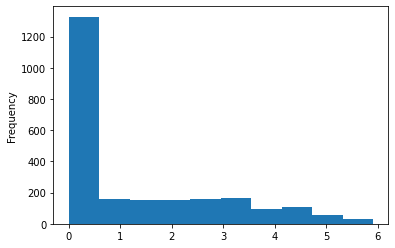

In [ ]:
mat_list0.band_gap.plot(kind='hist')  # Bandgap histogram
# most of bandgaps are between 0 and 0.5 eV

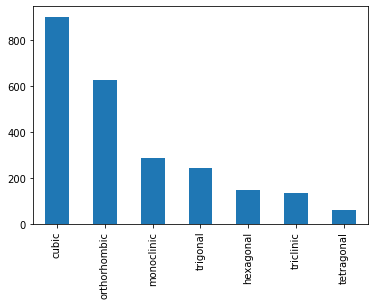

In [ ]:
mat_list0.crystal_system.value_counts().plot(kind='bar')  # Distribution of crystal phases

In [ ]:
mat_list0.groupby('crystal_system')['band_gap'].describe() # Gives the bandgap (describe()) statistics for each crystal phase

,count,mean,std,min,25%,50%,75%,max
crystal_system,,,,,,,,
cubic,900.0,0.299393,0.848549,0.0,0.000000,0.00000,0.000000,5.7371
hexagonal,146.0,1.106845,1.326495,0.0,0.000000,0.46975,2.077600,5.1115
monoclinic,287.0,2.117925,1.747984,0.0,0.322350,1.99650,3.431050,5.6554
orthorhombic,626.0,1.766396,1.690131,0.0,0.000000,1.49845,3.070125,5.8359
tetragonal,61.0,1.763107,1.594193,0.0,0.000000,1.66030,3.459900,4.7722
triclinic,134.0,1.778943,1.654497,0.0,0.233575,1.35840,3.068000,5.5411
trigonal,244.0,1.886797,1.693106,0.0,0.000000,1.93530,3.067825,5.9063


#### Stable materials
Materials that are within Convex Hull (e_above_hull, more stable than their competing phases).

In [ ]:
mat_list1 = mat_list0[mat_list0['e_above_hull']==0] # only elements with e_above_hull equals to zero, define new dataframe

In [ ]:
mat_list1.describe() # only 317 compound now, compared to 2398 before

,band_gap,formation_energy_per_atom,e_above_hull,symprec,number
count,317.000000,317.000000,317.0,3.170000e+02,317.000000
mean,1.912584,-2.527245,0.0,1.000000e-01,100.627760
std,1.688229,0.771625,0.0,1.389973e-17,74.309694
min,0.000000,-3.987759,0.0,1.000000e-01,1.000000
25%,0.000000,-3.122342,0.0,1.000000e-01,57.000000
50%,1.835700,-2.570995,0.0,1.000000e-01,62.000000
75%,3.234000,-2.025636,0.0,1.000000e-01,167.000000
max,5.655400,-0.405449,0.0,1.000000e-01,227.000000


### Fabrication

This data cannot be found in Materials Project. 
Lets use another database https://github.com/CederGroupHub/text-mined-synthesis_public. It uses NLP to read scientific articles and extract the fabrication process.

3 files to notice: <code>.json</code> compressed in <code>.xz</code>. Lets use the <code>solid-state_dataset_2019-12-03.json.xz</code>.

In [ ]:
!wget https://github.com/CederGroupHub/text-mined-synthesis_public/raw/master/solid-state_dataset_2019-12-03.json.xz && xz -d solid-state_dataset_2019-12-03.json.xz

--2022-12-05 10:59:13--  https://github.com/CederGroupHub/text-mined-synthesis_public/raw/master/solid-state_dataset_2019-12-03.json.xz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CederGroupHub/text-mined-synthesis_public/master/solid-state_dataset_2019-12-03.json.xz [following]
--2022-12-05 10:59:14--  https://raw.githubusercontent.com/CederGroupHub/text-mined-synthesis_public/master/solid-state_dataset_2019-12-03.json.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3391040 (3.2M) [application/octet-stream]
Saving to: ‘solid-state_dataset_2019-12-03.json.xz’

solid-state_dataset 100%[===

In [ ]:
synth_data = pd.read_json('solid-state_dataset_2019-12-03.json') # Charges .json into DataFrame

In [ ]:
synth_data.head()

,release_date,reactions
0,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.027', ..."
1,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.029', ..."
2,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.07.041', ..."
3,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.08.018', ..."
4,2019-12-03,"{'doi': '10.1016/j.materresbull.2007.08.018', ..."


In [ ]:
len(synth_data) # Entries, 30031 synthesis routes

30031

In [ ]:
synth_data['reactions'][0].keys() # reaction column has dictionary as inputs

dict_keys(['doi', 'targets_string', 'reaction_string', 'reaction', 'target', 'precursors', 'operations', 'paragraph_string'])

New columns for each key of dictionary with its value:

In [ ]:
synth_data[list(synth_data['reactions'][0].keys())] = synth_data.reactions.apply(pd.Series)
synth_data = synth_data.drop('reactions', axis=1) # deletes original reaction column

In [ ]:
synth_data.head()

,release_date,doi,targets_string,reaction_string,reaction,target,precursors,operations,paragraph_string
0,2019-12-03,10.1016/j.materresbull.2007.07.027,[Ba2HoTaO6],0.5 Ta2O5 + 2 BaCO3 + 0.5 Ho2O3 == 1 Ba2HoTaO6...,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'Ba2HoTaO6', 'material_for...","[{'material_string': 'Ta2O5', 'material_formul...","[{'token': 'dried', 'type': 'DryingOperation',...",All materials were obtained from Aldrich Chemi...
1,2019-12-03,10.1016/j.materresbull.2007.07.029,"[La3Nb0.5Ga5.3Al0.2O14, La3Nb0.5Ga5.3Al0.2O14]",1.5 La2O3 + 0.5*x Al2O3 + 2.75-0.5*x Ga2O3 + 0...,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'La3Nb0.5Ga5.5-xAlxO14', '...","[{'material_string': 'La2O3', 'material_formul...","[{'token': 'mixing', 'type': 'Mixing', 'condit...",The determination of the Al solubility limit i...
2,2019-12-03,10.1016/j.materresbull.2007.07.041,"[La9YGe6O27.005, La8.66YGe6O26.495, La8Y2Ge6O2...",0.5*x Y2O3 + 4.665+0.5*z-0.5*x La2O3 + 6 GeO2 ...,"{'element_substitution': {}, 'left_side': [{'m...",{'material_string': 'La9.33+z-xYx(GeO4)6O2+3z/...,"[{'material_string': 'Y2O3', 'material_formula...","[{'token': 'mixed', 'type': 'Mixing', 'conditi...","Samples, La9.33+z-xYx(GeO4)6O2+3z/2 (0 ≤ z ≤ 0..."
3,2019-12-03,10.1016/j.materresbull.2007.08.018,[CaTi4Cu3O12],3 CuO + 4 TiO2 + 1 CaCO3 == 1 CaCu3Ti4O12 + 1 CO2,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'CaCu3Ti4O12 oxide', 'mate...","[{'material_string': 'CuO', 'material_formula'...","[{'token': 'milled', 'type': 'LiquidGrinding',...","High-purity CaCO3 (99.99%), CuO (99.99%), and ..."
4,2019-12-03,10.1016/j.materresbull.2007.08.018,[Nb2ZnO6],1 ZnO + 1 Nb2O5 == 1 ZnNb2O6,"{'element_substitution': {}, 'left_side': [{'m...","{'material_string': 'ZnNb2O6', 'material_formu...","[{'material_string': 'ZnO', 'material_formula'...","[{'token': 'milled', 'type': 'Mixing', 'condit...",ZnNb2O6 powder was synthesized using high-puri...


Lets try to check if the compounds in <code>target</code> are in our original list of compounds: 

In [ ]:
synth_data['target'][0].keys()

dict_keys(['material_string', 'material_formula', 'composition', 'amounts_vars', 'elements_vars', 'additives', 'oxygen_deficiency', 'mp_id'])

In [ ]:
# again, lets turn the dict into columns
synth_data[list(synth_data['target'][0].keys())] = synth_data.target.apply(pd.Series)
synth_data = synth_data.drop('target', axis=1) # deletes original

In [ ]:
synth_data.head()

,release_date,doi,targets_string,reaction_string,reaction,precursors,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
0,2019-12-03,10.1016/j.materresbull.2007.07.027,[Ba2HoTaO6],0.5 Ta2O5 + 2 BaCO3 + 0.5 Ho2O3 == 1 Ba2HoTaO6...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'Ta2O5', 'material_formul...","[{'token': 'dried', 'type': 'DryingOperation',...",All materials were obtained from Aldrich Chemi...,Ba2HoTaO6,Ba2HoTaO6,"[{'formula': 'Ba2HoTaO6', 'elements': {'Ba': '...",{},{},[],None,mp-13000
1,2019-12-03,10.1016/j.materresbull.2007.07.029,"[La3Nb0.5Ga5.3Al0.2O14, La3Nb0.5Ga5.3Al0.2O14]",1.5 La2O3 + 0.5*x Al2O3 + 2.75-0.5*x Ga2O3 + 0...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'La2O3', 'material_formul...","[{'token': 'mixing', 'type': 'Mixing', 'condit...",The determination of the Al solubility limit i...,La3Nb0.5Ga5.5-xAlxO14,La3Nb0.5Ga5.5-xAlxO14,"[{'formula': 'La3Nb0.5Ga5.5-xAlxO14', 'element...","{'x': {'values': [0.2, 0.2], 'max_value': 0.2,...",{},[],None,None
2,2019-12-03,10.1016/j.materresbull.2007.07.041,"[La9YGe6O27.005, La8.66YGe6O26.495, La8Y2Ge6O2...",0.5*x Y2O3 + 4.665+0.5*z-0.5*x La2O3 + 6 GeO2 ...,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'Y2O3', 'material_formula...","[{'token': 'mixed', 'type': 'Mixing', 'conditi...","Samples, La9.33+z-xYx(GeO4)6O2+3z/2 (0 ≤ z ≤ 0...",La9.33+z-xYx(GeO4)6O2+3z/2,La9.33+z-xYx(GeO4)6O2+3z/2,"[{'formula': 'La9.33+z-xYx(GeO4)6O2+3z/2', 'el...","{'z': {'values': [0.67, 0.33], 'max_value': 0....",{},[],None,None
3,2019-12-03,10.1016/j.materresbull.2007.08.018,[CaTi4Cu3O12],3 CuO + 4 TiO2 + 1 CaCO3 == 1 CaCu3Ti4O12 + 1 CO2,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'CuO', 'material_formula'...","[{'token': 'milled', 'type': 'LiquidGrinding',...","High-purity CaCO3 (99.99%), CuO (99.99%), and ...",CaCu3Ti4O12 oxide,CaCu3Ti4O12 oxide,"[{'formula': 'CaCu3Ti4O12', 'elements': {'Ca':...",{},{},[],None,mp-22592
4,2019-12-03,10.1016/j.materresbull.2007.08.018,[Nb2ZnO6],1 ZnO + 1 Nb2O5 == 1 ZnNb2O6,"{'element_substitution': {}, 'left_side': [{'m...","[{'material_string': 'ZnO', 'material_formula'...","[{'token': 'milled', 'type': 'Mixing', 'condit...",ZnNb2O6 powder was synthesized using high-puri...,ZnNb2O6,ZnNb2O6,"[{'formula': 'ZnNb2O6', 'elements': {'Zn': '1'...",{},{},[],None,None


 <code>mp_id</code> column: identification inside materialsproject.org, let's then compare the two dataframes.

In [ ]:
mat_list2 = mat_list1.merge(synth_data, left_on='material_id', right_on='mp_id')

In [ ]:
mat_list2.head()

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,...,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
0,mp-1189614,[189333],BaThO3,"[Ba, O, Th]",4.0440,-3.784274,0.0,0.1,spglib,Pnma,...,"[{'token': 'mixed', 'type': 'Mixing', 'conditi...",The polycrystalline BaThO3 sample was prepared...,BaThO3,BaThO3,"[{'formula': 'BaThO3', 'elements': {'Ba': '1',...",{},{},[],None,mp-1189614
1,mp-13863,[23925],BaGeO3,"[Ba, Ge, O]",3.5490,-2.706277,0.0,0.1,spglib,P2_12_12_1,...,"[{'token': 'heated', 'type': 'HeatingOperation...",The phase evolution during the thermal decompo...,BaGeO3,BaGeO3,"[{'formula': 'BaGeO3', 'elements': {'Ba': '1',...",{},{},[],None,mp-13863
2,mp-13863,[23925],BaGeO3,"[Ba, Ge, O]",3.5490,-2.706277,0.0,0.1,spglib,P2_12_12_1,...,"[{'token': 'mixing', 'type': 'Mixing', 'condit...",The compositions of glasses studied are expres...,xBaO·(1-x)GeO2,xBaO·(1-x)GeO2,"[{'formula': 'BaO', 'elements': {'Ba': '1', 'O...",{},{},[],None,mp-13863
3,mp-13863,[23925],BaGeO3,"[Ba, Ge, O]",3.5490,-2.706277,0.0,0.1,spglib,P2_12_12_1,...,"[{'token': 'milled', 'type': 'Mixing', 'condit...",BaSn1-x/GexO3 powders with varying BaGeO3 cont...,BaGeO3,BaGeO3,"[{'formula': 'BaGeO3', 'elements': {'Ba': '1',...",{},{},[],None,mp-13863
4,mp-18702,"[261322, 15436]",AgPO3,"[Ag, O, P]",2.0266,-1.969740,0.0,0.1,spglib,P2_1/c,...,"[{'token': 'mixed', 'type': 'Mixing', 'conditi...","The glassy nanocomposites, xAgI-(1 - x) (0.5Ag...",0.5Ag2O-0.5P2O5,0.5Ag2O-0.5P2O5,"[{'formula': 'Ag2O', 'elements': {'Ag': '2', '...",{},{},[],None,mp-18702


As it is possible to have more than one fabrication route for the same material, the df went from 317 to 851 lines. Let's remove the duplicates.

In [ ]:
len(mat_list2) #df with more lines due to duplicates in fabrication process

851

In [ ]:
mat_list3 = mat_list2.drop_duplicates(subset=['material_id']) 
# let's drop the duplicates basing on the column material_id

In [ ]:
len(mat_list3) # reduced df, only 79 materials inside the requirements below

79

Only 79 materials (<code>mat_list3</code>) fufill all the criteria desired:

- [x] Perovskite materials
- [x] Known fabrication
- [x] e_hull > 0


Final df is:

In [ ]:
mat_list3['pretty_formula'].values # the compounds

array(['BaThO3', 'BaGeO3', 'AgPO3', 'CaRuO3', 'BaSnO3', 'BaCeO3', 'BaUO3',
       'BaZrO3', 'CaTiO3', 'CaSnO3', 'CaIrO3', 'CaZrO3', 'BaTiO3',
       'BaTeO3', 'AgSbO3', 'CdSiO3', 'CaSiO3', 'BaRuO3', 'BaSiO3',
       'BaHfO3', 'EuTiO3', 'EuZrO3', 'EuCrO3', 'GdInO3', 'ErCrO3',
       'ErMnO3', 'KBiO3', 'CsVO3', 'DyMnO3', 'GePbO3', 'NaNbO3', 'NaOsO3',
       'LuMnO3', 'LaCrO3', 'LaNiO3', 'LiVO3', 'LaAlO3', 'LaScO3', 'KTaO3',
       'LiTaO3', 'MgTiO3', 'NaTaO3', 'NaSbO3', 'KSbO3', 'NaPO3', 'NiPbO3',
       'NaVO3', 'TbCoO3', 'SmCoO3', 'PrCoO3', 'SmFeO3', 'SrPbO3',
       'SiPbO3', 'NdNiO3', 'SmMnO3', 'PrMnO3', 'NdCoO3', 'SrSnO3',
       'RbTaO3', 'SmRhO3', 'SrHfO3', 'PrAlO3', 'SrSiO3', 'SrZrO3',
       'SrTiO3', 'SrFeO3', 'SrMnO3', 'NdAlO3', 'SmAlO3', 'VAgO3', 'YRhO3',
       'TiCdO3', 'YCrO3', 'TiNiO3', 'TiMnO3', 'TiPbO3', 'TePbO3',
       'TmMnO3', 'VCdO3'], dtype=object)

Let's take one of them to study in depth: **TiPbO3**

In [ ]:
selected_material = mat_list2[mat_list2['pretty_formula']=='TiPbO3'] 
# select all features of this material

In [ ]:
selected_material

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,...,operations,paragraph_string,material_string,material_formula,composition,amounts_vars,elements_vars,additives,oxygen_deficiency,mp_id
830,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,[],"The (1-x)BF-x(0.9PMN-0.1PT) (where x = 10, 20,...",PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
831,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'calcined', 'type': 'HeatingOperati...",The constituents of multiferroic composites na...,PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
832,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'milled', 'type': 'LiquidGrinding',...",The materials of PbTiO3-BiScO3-Bi(Zn1/2Zr1/2)O...,PT-BS100x-BZZ100y,PT-BS100x-BZZ100y,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
833,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'ground', 'type': 'Mixing', 'condit...","About 16.5 mmol of PbO (98.5-99.0% purity, Eci...",PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
834,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'mixed', 'type': 'Mixing', 'conditi...","Then, appropriate amounts of starting oxides, ...",PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
835,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'mixed', 'type': 'Mixing', 'conditi...",BaTiO3 and PbTiO3 catalysts were prepared thro...,PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
836,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'mixing', 'type': 'Mixing', 'condit...","Laboratory-grade purity oxides of lead oxide, ...",PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
837,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'calcining', 'type': 'HeatingOperat...",Columbite technique was first used to produce ...,PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
838,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'ground', 'type': 'Mixing', 'condit...",PT ceramics were prepared from commercial grad...,PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459
839,mp-20459,"[1611, 55060, 61169, 162048, 162045, 186727, 5...",TiPbO3,"[Ti, Pb, O]",1.9569,-2.739866,0.0,0.1,spglib,P4mm,...,"[{'token': 'mixed', 'type': 'LiquidGrinding', ...",Polycrystalline samples of (PZT)0.9(BiZnT)0.1 ...,PbTiO3,PbTiO3,"[{'formula': 'PbTiO3', 'elements': {'Pb': '1',...",{},{},[],None,mp-20459


In [ ]:
selected = 'mp-20459' # ID Materials Project

In [ ]:
selected_material.keys() # features

Index(['material_id', 'icsd_ids', 'pretty_formula', 'elements', 'band_gap',
       'formation_energy_per_atom', 'e_above_hull', 'symprec', 'source',
       'symbol', 'number', 'point_group', 'crystal_system', 'hall',
       'release_date', 'doi', 'targets_string', 'reaction_string', 'reaction',
       'precursors', 'operations', 'paragraph_string', 'material_string',
       'material_formula', 'composition', 'amounts_vars', 'elements_vars',
       'additives', 'oxygen_deficiency', 'mp_id'],
      dtype='object')

### Synthesis Route of **TiPbO3**

In [ ]:
selected_material['reaction_string'].values # synthesis equation

array(['1 PbO + 1 TiO2 == 1 PbTiO3', '1 PbO + 1 TiO2 == 1 PbTiO3',
       '1 TiO2 + 1 PbO == 1 PbTiO3', '1 PbO + 1 TiO2 == 1 PbTiO3',
       '1 PbO + 1 TiO2 == 1 PbTiO3', '1 TiO2 + 1 PbO == 1 PbTiO3',
       '1 TiO2 + 1 PbO == 1 PbTiO3', '1 TiO2 + 1 PbO == 1 PbTiO3',
       '1 TiO2 + 1 PbCO3 == 1 PbTiO3 + 1 CO2',
       '1 PbO + 1 TiO2 == 1 PbTiO3', '1 PbO + 1 TiO2 == 1 PbTiO3',
       '1 TiO2 + 1 PbO == 1 PbTiO3',
       '1 PbCO3 + 1 TiO2 == 1 PbTiO3 + 1 CO2',
       '1 TiO2 + 1 Pb(NO3)2 + 2 [OH-] == 1 PbTiO3 + 1 H2O + 2 [NO3-]',
       '1 PbO + 1 TiO2 == 1 PbTiO3', '1 PbO + 1 TiO2 == 1 PbTiO3',
       '1 PbO + 1 TiO2 == 1 PbTiO3'], dtype=object)

In [ ]:
selected_material['operations'].values # recipy for fabrication

array([list([]),
       list([{'token': 'calcined', 'type': 'HeatingOperation', 'conditions': {'heating_temperature': [{'max_value': 600.0, 'min_value': None, 'values': [600.0], 'units': 'C'}], 'heating_time': [{'max_value': 2.0, 'min_value': None, 'values': [2.0], 'units': 'h'}], 'heating_atmosphere': ['air'], 'mixing_media': [], 'mixing_device': []}}]),
       list([{'token': 'milled', 'type': 'LiquidGrinding', 'conditions': {'heating_temperature': [], 'heating_time': [], 'heating_atmosphere': [], 'mixing_media': ['alcohol'], 'mixing_device': []}}, {'token': 'milling', 'type': 'Mixing', 'conditions': None}, {'token': 'ground', 'type': 'Mixing', 'conditions': None}, {'token': 'sintered', 'type': 'HeatingOperation', 'conditions': None}, {'token': 'pressed', 'type': 'ShapingOperation', 'conditions': None}, {'token': 'sintered', 'type': 'HeatingOperation', 'conditions': {'heating_temperature': [{'max_value': 1150.0, 'min_value': 1050.0, 'values': [], 'units': 'C'}], 'heating_time': [{'ma

### Electronic Structure **TiPbO3**

From Materials Project:

In [ ]:
with MPRester(apikey) as mpr:
    bs = mpr.get_bandstructure_by_material_id(selected) # using MP id

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [ ]:
bs.get_band_gap() # type of electronic transition

{'direct': False,
 'energy': 1.8242000000000003,
 'transition': 'X-(0.000,0.000,0.464)'}

In [ ]:
efermi=bs.efermi
print(efermi)  # Fermi energy eV

4.72715899


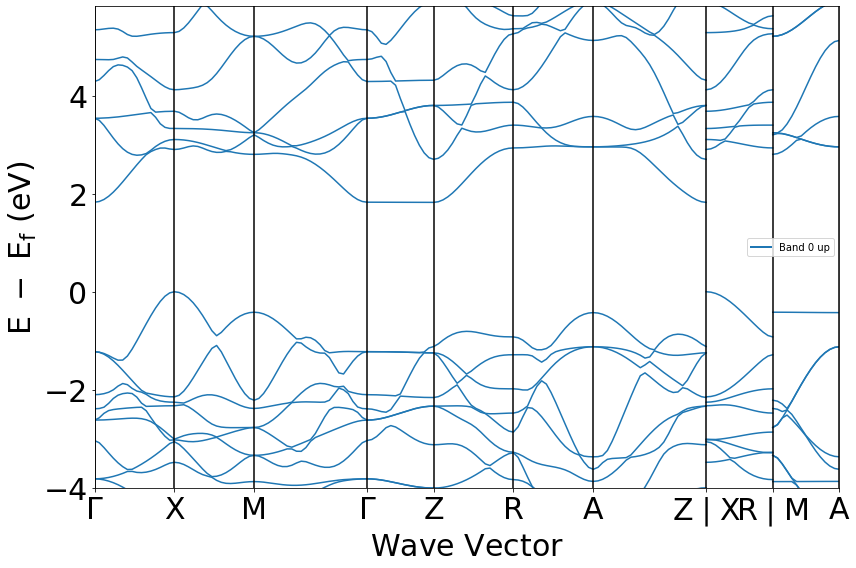

In [ ]:
bsp = BSPlotter(bs)
bsp.get_plot(zero_to_efermi=True).show() # Pymatgen automatic plotting
#bsp.bs_plot_data(zero_to_efermi=True)   # Extract in the dict form to plot manually

### Crystal Structure **TiPbO3**

Downloaded from Materials Project (it is also possible to use <code>bs</code> to store the crystal structure information).

In [ ]:
with MPRester(apikey) as mpr:
    structure = mpr.get_structure_by_material_id(selected)

/usr/local/lib/python3.8/dist-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [ ]:
structure.atomic_numbers

(22, 82, 8, 8, 8)

In [ ]:
structure.cart_coords # atomic positions

array([[1.9306075 , 1.9306075 , 2.4103425 ],
       [0.        , 0.        , 4.48460305],
       [1.9306075 , 1.9306075 , 0.65912021],
       [0.        , 1.9306075 , 2.89958479],
       [1.9306075 , 0.        , 2.89958479]])

In [ ]:
structure.lattice # lattice parameters

Lattice
    abc : 3.861215 3.861215 4.627061
 angles : 90.0 90.0 90.0
 volume : 68.98476581295094
      A : 3.861215 0.0 0.0
      B : 0.0 3.861215 0.0
      C : 0.0 0.0 4.627061
    pbc : True True True

## Lets use the `mat_list1` to find the polar structures

In [ ]:
from pymatgen.symmetry.groups import SpaceGroup, SYMM_DATA, sg_symbol_from_int_number

In [ ]:
# This is a list of the point groups as noted in pymatgen
point_groups = []
for i in range(1,231):
    symbol = sg_symbol_from_int_number(i)
    point_groups.append(SYMM_DATA['space_group_encoding'][symbol]['point_group'])

# # Note that there are 40 of them, rather than 32.
print("Number of point groups denoted in pymatgen: ", len(set(point_groups)))

# This is because multiple conventions are used for the same point group.
# This dictionary can be used to convert between them.
point_group_conv = {'321' :'32', '312': '32', '3m1' :'3m', '31m': '3m',
                    '-3m1' : '-3m', '-31m': '-3m', '-4m2': '-42m', '-62m': '-6m2' }

# Using this dictionary we can correct to the standard point group notation.
corrected_point_groups = [point_group_conv.get(pg, pg) for pg in point_groups]
# Which produces the correct number of point groups. 32.
print("Number of point groups in conventional notation: ", len(set(corrected_point_groups)))

Number of point groups denoted in pymatgen:  40
Number of point groups in conventional notation:  32


In [ ]:
# There are 10 polar point groups
polar_point_groups = ['1', '2', 'm', 'mm2', '4', '4mm', '3', '3m', '6', '6mm']

# Polar spacegroups have polar point groups.
polar_spacegroups = []
# There are 230 spacegroups
for i in range(1,231):
    symbol = sg_symbol_from_int_number(i)
    pg = SYMM_DATA['space_group_encoding'][symbol]['point_group']
    if point_group_conv.get(pg, pg) in polar_point_groups:
        polar_spacegroups.append(i)
        
# 68 of the 230 spacegroups are polar.
print("Number of polar spacegroups: ", len(polar_spacegroups))

Number of polar spacegroups:  68


In [ ]:
type(polar_spacegroups)

list

In [ ]:
# polar_spacegroups

In [ ]:
# test = mat_list1["number"].apply(lambda mentions: list(set(mentions).intersection(polar_spacegroups)))
test = mat_list1["number"].map(lambda x: np.intersect1d(x, polar_spacegroups))
test, type(test)

(28      []
 46      []
 57      []
 58      []
 63      []
         ..
 2304    []
 2315    []
 2320    []
 2321    []
 2337    []
 Name: number, Length: 317, dtype: object, pandas.core.series.Series)

In [ ]:
test.describe

In [ ]:
test2 = mat_list0["number"].map(lambda x: np.intersect1d(x, polar_spacegroups)).str.join(', ')
test2, type(test2)

(0          
 1          
 2          
 3          
 4          
        ... 
 2393       
 2394       
 2395       
 2396       
 2397    NaN
 Name: number, Length: 2398, dtype: object, pandas.core.series.Series)

In [ ]:
mat_list0[mat_list0["number"].isin(polar_spacegroups)] # make the same for non polar space groups and then create a machine learning model to predict if something is polar or not

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall
26,mp-1076932,[161419],BaTiO3,"[Ba, O, Ti]",0.0000,-2.522488,0.979015,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
44,mp-1178561,[],AgClO3,"[Ag, Cl, O]",2.8464,-0.482895,0.062126,0.1,spglib,R3m,160,3m,trigonal,"R 3 -2"""
45,mp-1178562,[],AgBrO3,"[Ag, Br, O]",2.5145,-0.296269,0.001173,0.1,spglib,R3m,160,3m,trigonal,"R 3 -2"""
55,mp-1182337,[],BaClO3,"[Ba, Cl, O]",0.1709,-1.288107,0.497629,0.1,spglib,P1,1,1,triclinic,P 1
145,mp-1205336,"[89996, 89995]",BaMnO3,"[Ba, Mn, O]",1.8948,-2.494128,0.000000,0.1,spglib,P6_3mc,186,mm2,hexagonal,P 6c -2c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386,mvc-3769,[],YMoO3,"[Y, Mo, O]",0.0000,-2.674721,0.299691,0.1,spglib,P6_3cm,185,6mm,hexagonal,P 6c -2
2387,mvc-3770,[],YVO3,"[O, V, Y]",0.0000,-3.029377,0.250791,0.1,spglib,P6_3cm,185,6mm,hexagonal,P 6c -2
2388,mvc-3772,[],YWO3,"[O, W, Y]",0.0000,-2.561029,0.398052,0.1,spglib,P6_3cm,185,6mm,hexagonal,P 6c -2
2389,mvc-3773,[],YNiO3,"[Ni, O, Y]",0.0000,-2.145242,0.262901,0.1,spglib,P6_3cm,185,6mm,hexagonal,P 6c -2


In [ ]:
mat_list0[mat_list0["number"] == 38]

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall
26,mp-1076932,[161419],BaTiO3,"[Ba, O, Ti]",0.0000,-2.522488,0.979015,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
155,mp-1227991,[],BaInO3,"[Ba, In, O]",0.0000,-2.139200,0.108299,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
321,mp-5777,"[31155, 237106, 73639, 73640, 73641, 237109, 1...",BaTiO3,"[Ba, Ti, O]",2.3733,-3.501030,0.000473,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
330,mp-644497,[154346],BaTiO3,"[Ba, Ti, O]",0.5466,-2.787271,0.714232,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
447,mp-995191,[161341],BaTiO3,"[Ba, Ti, O]",0.0000,-1.694888,1.806615,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
815,mp-5246,"[14363, 9533, 190922]",KNbO3,"[K, Nb, O]",2.1256,-2.865365,0.000134,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
1670,mp-1281764,"[184078, 77142]",SrCoO3,"[Co, O, Sr]",0.0000,-2.001234,0.037374,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
2165,mp-20337,[39607],ZrPbO3,"[Zr, Pb, O]",3.2477,-2.852447,0.032541,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2
2397,mvc-5731,[],ZnWO3,"[O, W, Zn]",0.0000,-1.328743,0.563319,0.1,spglib,Amm2,38,mm2,orthorhombic,A 2 -2


In [ ]:
test2[0]

0    0         []
1         []
2         []
3      ...
Name: 0, dtype: object

In [ ]:
banana = pd.DataFrame([test2],columns=['A'])
banana.value_counts()

ValueError: ignored

In [ ]:
mat_list1[mat_list1["number"] == 37]

,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall


In [ ]:
mat_list1


,material_id,icsd_ids,pretty_formula,elements,band_gap,formation_energy_per_atom,e_above_hull,symprec,source,symbol,number,point_group,crystal_system,hall
28,mp-1078659,[164774],CaRhO3,"[Ca, O, Rh]",0.0000,-2.108324,0.0,0.1,spglib,Cmcm,63,mmm,orthorhombic,-C 2c 2
46,mp-1178563,[],AgAsO3,"[Ag, As, O]",0.2921,-1.283287,0.0,0.1,spglib,R-3,148,-3,trigonal,-R 3
57,mp-1183053,[],AcGaO3,"[Ac, Ga, O]",2.8966,-3.072431,0.0,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
58,mp-1183115,[],AcAlO3,"[Ac, Al, O]",4.1024,-3.699194,0.0,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
63,mp-1183139,[],AcNiO3,"[Ac, Ni, O]",0.0000,-2.389306,0.0,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,mp-769404,[],YSeO3,"[O, Se, Y]",1.8220,-2.516999,0.0,0.1,spglib,P2_1/c,14,2/m,monoclinic,-P 2ybc
2315,mp-780387,[],YbHfO3,"[Hf, O, Yb]",4.5175,-3.980304,0.0,0.1,spglib,Pnma,62,mmm,orthorhombic,-P 2ac 2n
2320,mp-865322,[],UTlO3,"[U, Tl, O]",0.3286,-2.949918,0.0,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3
2321,mp-865758,[],YbGeO3,"[Ge, O, Yb]",1.0937,-2.775506,0.0,0.1,spglib,Pm-3m,221,m-3m,cubic,-P 4 2 3


Let's save the structure in a file of type <code>POSCAR</code> inside the folder <code>proto_CaAlF5</code>, located inside <code>ht</code>. 

In [ ]:
poscar = vasp.inputs.Poscar(structure) 
# using the vasp library to generate the Poscar file

In [ ]:
# creating folder names for high-throughput
master_folder = 'ht'
material_folder = 'proto_CaAlF5'
filename = 'POSCAR'

In [ ]:
# creating folders for high-throughput
os.mkdir(master_folder)
os.mkdir(master_folder+'/'+material_folder)

In [ ]:
# writing the POSCAR file inside created folders
poscar.write_file(master_folder+'/'+material_folder+'/'+filename)

Target question: **if we can each element of this compound for another one with similar chemical properties, do we still get a UWBG stable and possible to fabricate?**

- UWBG: ultrawide bandgap
-------------------------------------------------

# Parte 2 - Configurating entries for HT jobs 

The substitution of elements will be done by using other elements of the same column in the periodic table (not considering radioactive ones such as Ra and At).

As a quantum mechanics solver, let's use the VASP code.

The calculations will be carried in a cluster using a queue manager such as SLURM.

obs: for calculation clusters without queue manager, better to use ASE (https://wiki.fysik.dtu.dk/ase/) to submit the calculations directly using Python. For sending high quantity of jobs, also using queue manager, better to use AiiDA (https://www.aiida.net/).

### Creating new materials and configurating VASP files

- Launching jobs to calculate the ionic positions and optimize structure (to converge!)

- Lets use the same crystal structure as **CaAlF5**, just changing the atoms

- Atoms to substitute: Be, Mg, Sr, Ba (columns 2 of periodic table); B, Ga, In, Tl (column 13) and Cl, Br, I (column 17); plus Ca, Al and F that I already had. 

- This gives a combination of 5 x 5 x 4, giving 100 compounds (but one, CaAlF5) I already have.

- Lets then simulate all the 99 in a high-throughput manner:

In [ ]:
input_folder = 'ht/proto_CaAlF5'  
# Our initial crystal structure (POSCAR) used as prototype
proto_poscar = Structure.from_file(input_folder+"/POSCAR")  
# propotype structure

In [ ]:
proto_poscar

Structure Summary
Lattice
    abc : 5.450502239609209 5.450502239609209 7.439762862459864
 angles : 69.98009713859915 69.98009713859915 71.99384548135231
 volume : 190.44989674275448
      A : 3.203488 4.409721 0.0
      B : -3.203488 4.409721 0.0
      C : 0.0 3.148114 6.740879
PeriodicSite: Ca (0.2659, 5.1967, 1.6852) [0.5415, 0.4585, 0.2500]
PeriodicSite: Ca (-0.2659, 6.7708, 5.0557) [0.4585, 0.5415, 0.7500]
PeriodicSite: Al (0.0000, 1.5741, 3.3704) [0.0000, 0.0000, 0.5000]
PeriodicSite: Al (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: F (-0.1096, 8.7920, 4.1360) [0.7608, 0.7950, 0.6136]
PeriodicSite: F (-0.1096, 4.7497, 5.9753) [0.2050, 0.2392, 0.8864]
PeriodicSite: F (0.1096, 3.1756, 2.6049) [0.2392, 0.2050, 0.3864]
PeriodicSite: F (0.1096, 7.2179, 0.7655) [0.7950, 0.7608, 0.1136]
PeriodicSite: F (-2.8318, 6.7708, 5.0557) [0.0580, 0.9420, 0.7500]
PeriodicSite: F (2.8318, 5.1967, 1.6852) [0.9420, 0.0580, 0.2500]
PeriodicSite: F (-1.3865, 4.5896, 0.1757) [0.2947, 0

Setting VASP configuration to launch jobs:

In [ ]:
incar_rx = {
"ALGO": "Normal",
"EDIFF": "0.000001",
"ENCUT": 520,
"IBRION": 2,
"ISIF": 3,
"ISMEAR": 0,
"ISPIN": 1,
"LASPH": True,
"LORBIT": 11,
"LREAL": "Auto",
"LWAVE": False,
"LCHARG":False,
"NELM": 100,
"NSW": 900,
"SIGMA": 0.05,
"NPAR": 6
}

auto_kpoints = 25

Creating the folder structure to launch the files containing all the new combination of compounds:

In [ ]:
# List of elements to substitute
earthalk_list = ['Be','Mg','Ca','Sr','Ba']
boron_list = ['B','Al','Ga','In','Tl']
halogen_list = ['F','Cl','Br','I']

In [ ]:
# generating 100 POSCAR files, for each element combination
# generates also the INCAR and KPOINTS input files requested by VASP

calculations_folder = 'ht/rx'
os.mkdir(calculations_folder)
pseudos_src_path = 'pp/'

for e1 in earthalk_list:
    for e2 in boron_list:
        for e3 in halogen_list:
            
            # New folder for new combination of materials
            output_folder=calculations_folder+'/'+e1+e2+e3+'5'
            os.mkdir(output_folder)
            
            temp_structure = proto_poscar.copy()          # Copy original structure

            if not(e1=='Ca' and e2=='Al' and e3=='F'):
                for i, element in enumerate(proto_poscar):    # for each atom in structure
                    element_str = str(element.species)        # take atom from site
                    element_str = element_str.replace('1','') # removes stoichiometry (in this case 1)

                    # change elements from the same family
                    if element_str in earthalk_list:
                        temp_structure.replace(i,e1)
                    elif element_str in boron_list:
                        temp_structure.replace(i,e2)
                    elif element_str in halogen_list:
                        temp_structure.replace(i,e3)

            # creates new POSCAR file in the final folder
            new_poscar = vasp.inputs.Poscar(temp_structure)
            new_poscar.write_file(output_folder+'/POSCAR')
            
            # creates new KPOINTQ file in the final folder
            kpoints = vasp.Kpoints().automatic(auto_kpoints)  # auto_kpoints (25)
            kpoints.write_file(output_folder+'/KPOINTS')
            
            # creates new INCAR file in the final folder
            incar = vasp.Incar(incar_rx)
            incar.write_file(output_folder+'/INCAR')
            
            # creates POTCAR in final folder:
            # create_potcar(compound, pseudos_src_path,  best_choice, dst_path)
            
            # creates job in final folder:
            # create_jobfile(protojob_path, job_name, time, job_dst_path)

FileExistsError: ignored

We can zip the files and then use them later to submit the jobs:

In [ ]:
!zip -r '/content/ht_todo.zip' '/content/ht/'

  adding: content/ht/ (stored 0%)
  adding: content/ht/rx/ (stored 0%)
  adding: content/ht/rx/CaGaF5/ (stored 0%)
  adding: content/ht/rx/CaGaF5/INCAR (deflated 25%)
  adding: content/ht/rx/CaGaF5/KPOINTS (deflated 9%)
  adding: content/ht/rx/CaGaF5/POSCAR (deflated 60%)
  adding: content/ht/rx/BaAlCl5/ (stored 0%)
  adding: content/ht/rx/BaAlCl5/INCAR (deflated 25%)
  adding: content/ht/rx/BaAlCl5/KPOINTS (deflated 9%)
  adding: content/ht/rx/BaAlCl5/POSCAR (deflated 61%)
  adding: content/ht/rx/MgBBr5/ (stored 0%)
  adding: content/ht/rx/MgBBr5/INCAR (deflated 25%)
  adding: content/ht/rx/MgBBr5/KPOINTS (deflated 9%)
  adding: content/ht/rx/MgBBr5/POSCAR (deflated 61%)
  adding: content/ht/rx/SrTlBr5/ (stored 0%)
  adding: content/ht/rx/SrTlBr5/INCAR (deflated 25%)
  adding: content/ht/rx/SrTlBr5/KPOINTS (deflated 9%)
  adding: content/ht/rx/SrTlBr5/POSCAR (deflated 61%)
  adding: content/ht/rx/CaBBr5/ (stored 0%)
  adding: content/ht/rx/CaBBr5/INCAR (deflated 25%)
  adding: content

----------------------------
### Annexe: how to create <code>JOB</code> and <code>POTCAR</code> files

<pre><code>
# INPUT: takes address of pseudopotential folder (full address of PBE, GGA, etc potencials)
# OUTPUT: creates POTCAR file and returns success flag (True) or fail (False)
def create_potcar(compound, pseudos_src_path,  best_choice, dst_path):

    # if the final folder does not exist:
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

    comp1 = Composition(compound)
    elements=[]
    final_file = []
    for elem in comp1.formula.split(" "):
        n = re.sub('\D', '', elem)
        element = elem.replace(n,'')

        if element in best_choice.keys():
            element_path = pseudos_src_path+'/'+element+best_choice[element]+'/POTCAR'
            #print(element_path)
            # if a better choice of PSEUDOS folder does not exist 
            if not(os.path.isfile(element_path)):
                element_path = pseudos_src_path+'/'+element+'/POTCAR'
        else:
             element_path = pseudos_src_path+'/'+element+'/POTCAR'

        #print(element_path)

        # if POTCAR file exists
        if os.path.isfile(element_path):
            with open(element_path, 'r') as file:
                x = file.readlines()
            final_file = final_file+x
            response=True
        else:
            print("Not found POTCAR of: "+element)
            response=False
            break

    if response and len(final_file)>0:
        complete_dst_path = dst_path+'/POTCAR'
        with open(complete_dst_path, 'w') as file:
            file.writelines(final_file)

    return response


# INPUT: job protopyte address, job name, time limit, output address
# OUTPUT: creates job file in final folder and returns success flag (True) or fail (False)
def create_jobfile(protojob_path, job_name, time, job_dst_path):

    if os.path.isfile(protojob_path):
        # creates folder to put job file inside in case it does not exists
        if not os.path.exists(job_dst_path):
            os.mkdir(job_dst_path)

        # charges job prototype
        with open(protojob_path, 'r') as file:
            job = file.readlines()

        new_job=[]
        for line in job:
            line = line.replace('jobname',job_name)
            line = line.replace('xx:xx:xx',time)
            new_job.append(line)

        complete_path = job_dst_path+'/'+job_name
        #complete_path = job_dst_path+'/JOB'

        with open(complete_path,'w') as file:
            file.writelines(new_job)

        response=True

    else:
        print('Job proto file not found')
        response = False

    return response
</code></pre>
------------------------------------------------

# Parte 3 - Submitting the jobs into a quantum mechanics solver (VASP code)

Below, let's use "pure python" to submit, but other libraries can be used: ASE (for a local computer) and AiiDA (for clusters with scheduler and complex job management. 

Use a dedicated script <code>.py</code>, to be charged inside the cluster. obs: <code>JOB</code> files needes to be inside the correct <code>folder</code> together with other inputs of Vasp.

#### Script for launching and managing <code>JOBS</code> inside cluster

<pre><code>
import os
import shutil
import time
import subprocess
import argparse

# Returns number of free spaces inside SLURM
def check_free_spot(user):

    temp = 'check_free_spot.txt'
    script = f'''squeue -u {user} > {temp}'''

    count_lines = subprocess.Popen(script, stdout=subprocess.PIPE, shell=True)
    time.sleep(2)
    with open(temp, 'r') as file:
        lines = file.readlines()

    n_lines = 21-len(lines)

    os.remove(temp)

    return n_lines

# Submits script command
def submit_job(job_path):

    job = job_path.split('/')[-1]
    shell_command='sbatch '+job
    job_path=job_path.replace(job,'')

    submit = subprocess.Popen(shell_command,
                              stdout=subprocess.PIPE,
                              shell=True,
                              cwd=job_path)
    status = submit.communicate()[0].decode('UTF-8')

    if status.split()[0] == 'Submitted':
        print('Submission successful.')
        response=True
    else:
        print('Submission failed.')
        response=False

    return(response)


def main():
    parser = argparse.ArgumentParser()

    parser.add_argument('-jb', '--jobs', default = 'jobs_submetidos.txt',
                        help = 'Nome do arquivo de jobs submetidos.', type = str)

    parser.add_argument('-fjb', '--fjobs', default = 'jobs_afazer',
                        help = 'Pasta com arquivos de jobs a serem submetidos.', type = str)

    parser.add_argument('-u', '--user', default = 'usuario_da_sd',
                        help = 'Usuario do SLURM.', type = str)

    args = parser.parse_args()
    # verifies is a file exists with the jobs already launched
    if not(os.path.isfile(args.jobs)):
        f= open(args.jobs,"w+")
        f.close()
        nfeitos=0
    else:
        with open(args.jobs, 'r') as file:
            jobs_prontos = file.readlines()
        nfeitos=len(jobs_prontos)


    sleep_time = 1800
    qts_jobs = len(os.listdir(args.fjobs))
    todo_jobs = qts_jobs-nfeitos # quantity of jobs to be done
    i = 0


    while(i<todo_jobs):

        with open(args.jobs, 'r') as file:
            jobs_prontos = file.readlines()

        jobs_prontos=[job.replace('\n','') for job in jobs_prontos] # So tira o \n

        for folder in os.listdir(args.fjobs):
            # O job ainda nao foi submetido
            if not(folder in jobs_prontos):
                n_lines = check_free_spot(args.user)
                # Tem espaco para colocar na fila
                if n_lines>0:
                    job_folder = args.fjobs+'/'+folder
                    job_file = [file for file in os.listdir(job_folder) if 'job' in file][0]
                    submit_job(job_folder+'/'+job_file)
                    with open(args.jobs, 'a') as file:
                        file.write(folder+'\n')
                    i = i+1
                else:
                    break
        time.sleep(sleep_time)

if __name__ == "__main__":
    main()
</code></pre>

-------------------------------

# Parte 4 - Data Analysis

Vamos analisar os resultados prontos após algumas etapas de contas, além da relaxação iônica. Metodologias DFT mais robustas pedem por uma etapa de otimização sem movimento iônico e um novo cálculo com os caminhos de alta simetria para obter o diagrama de bandas eletrônicas. Neste caso, vamos deixar mais simples sem perda de generalidade: tudo aqui mostrado pode ser adaptado para outras metodologias mudando os parâmetros do <code>INCAR</code> e <code>KPOINTS</code> para o caso do VASP, inclusive repetindo a Etapa 3 conforme o necessário. Outros *solvers* de mecânica quântica podem ser usados com integração com o <code>pymatgen</code> (veja https://pymatgen.org/pymatgen.io.html para informações sobre as interfaces com outros softwares de mecânica quântica).

Os resultados parciais aqui mostrados fazem parte de pesquisa em andamento, cuja última referência é:

- H. Ferreira, J. A. Souza, and G. M. Dalpian, **High-throughput Calculations to Discovery New Compounds: the case of Jakobssonite**, Encontro de Outono da Sociedade Brasileira de Física, 2022.


### Carregando os dados

O VASP gera vários arquivos de resultados, que podem ser carregados e examinados. Aqui estamos trabalhando apenas com um recorte desses arquivos <code>CONTCAR</code> (para estrutura cristalina) e <code>EIGENVAL</code> (para bandgap).

In [ ]:
# Copiando as informações do repositório do GITHUB
!wget https://github.com/simcomat/matinfo_tutorials/raw/main/ilum_2022/results_bs.rar -O results_bs.rar

--2022-10-28 09:31:37--  https://github.com/simcomat/matinfo_tutorials/raw/main/ilum_2022/results_bs.rar
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/simcomat/matinfo_tutorials/main/ilum_2022/results_bs.rar [following]
--2022-10-28 09:31:38--  https://raw.githubusercontent.com/simcomat/matinfo_tutorials/main/ilum_2022/results_bs.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8505656 (8.1M) [application/octet-stream]
Saving to: ‘results_bs.rar’

results_bs.rar      100%[===================>]   8.11M  --.-KB/s    in 0.09s   

2022-10-28 09:31:38 (91.1 MB/s) - ‘results_bs.rar’ saved [850565

In [ ]:
# Descompactando as informações no computador do Google Colab
!unrar x results_bs.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from results_bs.rar

Creating    results_bs                                                OK
Creating    results_bs/BaAlBr5                                        OK
Extracting  results_bs/BaAlBr5/CONTCAR                                     0%  OK 
Extracting  results_bs/BaAlBr5/EIGENVAL                                    0%  OK 
Creating    results_bs/BaAlCl5                                        OK
Extracting  results_bs/BaAlCl5/CONTCAR                                     0%  OK 
Extracting  results_bs/BaAlCl5/EIGENVAL                                    2%  OK 
Creating    results_bs/BaAlF5                                         OK
Extracting  results_bs/BaAlF5/CONTCAR                                      2%  OK 
Extracting  results_bs/BaAlF5/EIGENVAL                                     3%  OK 
Creating    results_bs/BaAlI5                          

In [ ]:
calculations_results = 'results_bs'
results = []
for e1 in earthalk_list:
    for e2 in boron_list:
        for e3 in halogen_list:
            
            folder=f'{calculations_results}/{e1}{e2}{e3}5'
            
            # Carrega os arquivos
            contcar = Structure.from_file(f'{folder}/CONTCAR')
            eigenval = vasp.outputs.Eigenval(f'{folder}/EIGENVAL')
            
            # Pega os atributos dos arquivos carregados e salva em um dicionário
            band = eigenval.eigenvalue_band_properties 

            proprieties = {
                'material':f'{e1}{e2}{e3}5',
                'A':e1,
                'B':e2,
                'C':e3,
                'bandgap':band[0],
                'cbm':band[1],
                'vbm':band[2],
                'bandgap_direct':band[3],
                'lattice_a':contcar.lattice.a,
                'lattice_b':contcar.lattice.b,
                'lattice_c':contcar.lattice.c,
                'lattice_alpha':contcar.lattice.alpha,
                'lattice_beta':contcar.lattice.beta,
                'lattice_gamma':contcar.lattice.gamma
            }
            results.append(proprieties) # Uma lista de objetos dict que será convertida em tabela
            

In [ ]:
results_df = pd.DataFrame(data=results)  # Colocando em uma tabela

In [ ]:
results_df.head()

,material,A,B,C,bandgap,cbm,vbm,bandgap_direct,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
0,BeBF5,Be,B,F,7.215247,4.623167,-2.592080,True,5.137239,5.141555,9.477953,123.430231,56.544091,122.173758
1,BeBCl5,Be,B,Cl,4.864420,1.425657,-3.438763,False,7.790373,7.762067,10.530760,115.351539,64.603085,108.196125
2,BeBBr5,Be,B,Br,3.883992,0.861019,-3.022973,False,8.186414,8.214125,11.804317,116.866052,63.329587,117.455505
3,BeBI5,Be,B,I,2.766870,2.010463,-0.756407,False,8.628103,8.648576,11.983029,115.132217,64.378342,114.868954
4,BeAlF5,Be,Al,F,7.786402,6.512569,-1.273833,True,4.811944,4.811913,7.439838,112.740046,67.273112,98.664274


In [ ]:
len(results_df)

100

As estatísticas básicas podem ser obtidas usando o comando <code>.describe</code> sobre a variável <code>results</code> que armazena os dados de resultados carregados numa estrutura de dados <code>DataFrame</code>:

In [ ]:
results_df.describe()

,bandgap,cbm,vbm,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.298613,2.355679,-0.942934,7.269389,7.200288,10.788109,113.984287,71.342997,103.966979
std,1.751008,1.402202,1.403827,1.510483,1.443463,2.020007,5.282402,15.696749,11.686330
min,0.000252,-1.935510,-3.438763,4.811944,4.811913,7.295984,101.450104,50.172336,73.694311
25%,1.951422,1.438639,-1.854169,6.448909,6.348501,9.289077,110.249121,63.283595,93.938542
50%,3.006526,2.484666,-1.048037,7.270441,7.291892,10.967104,112.338908,67.687879,106.562708
75%,4.704026,3.404987,-0.219678,7.847228,7.734614,12.058363,116.229366,69.901668,114.082750
max,7.786402,6.512569,5.473483,16.659805,16.659805,18.412130,131.019347,112.291659,128.002970


### Gerando gráficos
Para gerar gráficos dedicados utilizamos as bibliotecas <code>matplotlib</code> e <code>seaborn</code>. Figuras mais elaboradas podem ser feitas usandos os parâmetros dos métodos das bibliotecas de plot (<code>matplotlib</code> e <code>seaborn</code> - também é possível usar <code>latex</code> caso haja uma instalação local do mesmo e um módulo de compatibilidade instalado).


Primeiro vamos plotar a **dispersão** do bandgap em função dos parâmetros da estrutura cristalina:

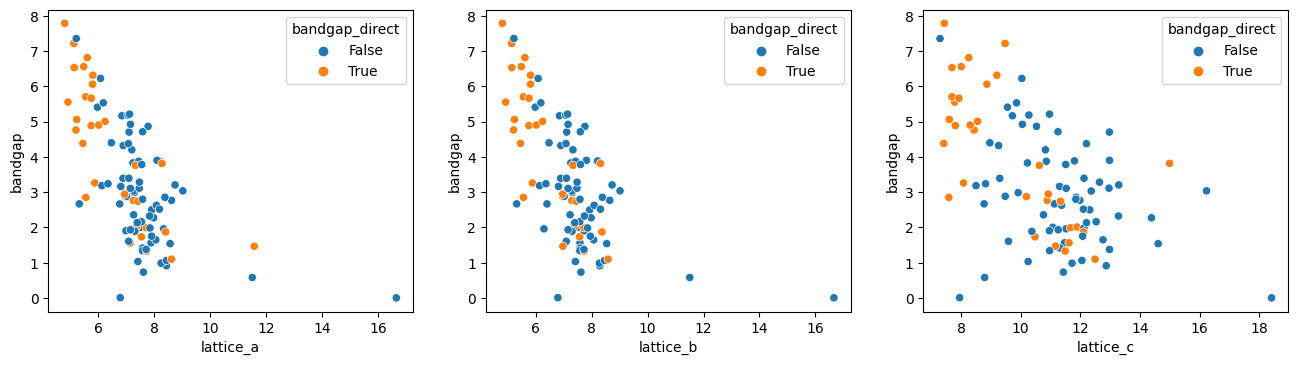

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100) # Cria a imagem com 1 linha e 3 colunas (subplots)

sns.scatterplot(data=results_df, x="lattice_a", y="bandgap", hue='bandgap_direct', ax=ax[0])
sns.scatterplot(data=results_df, x="lattice_b", y="bandgap", hue='bandgap_direct', ax=ax[1])
sns.scatterplot(data=results_df, x="lattice_c", y="bandgap", hue='bandgap_direct', ax=ax[2])

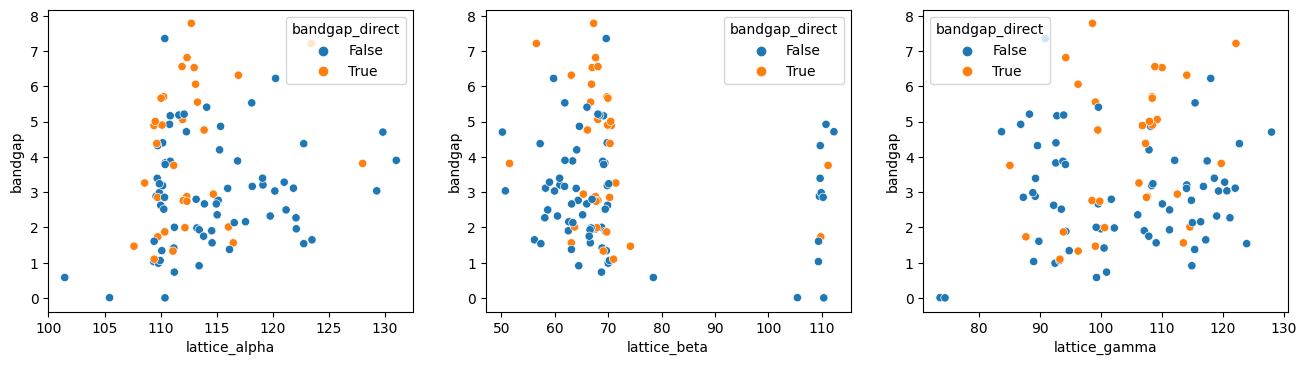

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4), dpi=100)

sns.scatterplot(data=results_df, x="lattice_alpha", y="bandgap", hue='bandgap_direct', ax=ax[0])
sns.scatterplot(data=results_df, x="lattice_beta", y="bandgap", hue='bandgap_direct', ax=ax[1])
sns.scatterplot(data=results_df, x="lattice_gamma", y="bandgap", hue='bandgap_direct', ax=ax[2])

Vamos observar as estatísticas do bandgap em função do grupo de elementos químicos através de gráficos **boxplot**:

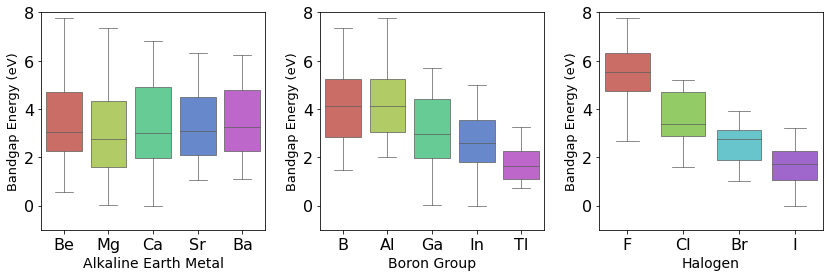

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.boxplot(x="A", y="bandgap", data=results_df,
            palette="hls", linewidth=0.7, ax=axes[0],
            order=['Be','Mg','Ca','Sr', 'Ba'],
           )

sns.boxplot(x="B", y="bandgap", data=results_df, 
            palette="hls", linewidth=0.7, ax=axes[1],
            order=['B','Al','Ga','In', 'Tl'],
           )

sns.boxplot(x="C", y="bandgap", data=results_df,
            palette="hls", linewidth=0.7, ax=axes[2],
            order=['F','Cl','Br','I'],
           )

### Ajustes
axes[0].set_xlabel('Alkaline Earth Metal',  fontsize=14)
axes[1].set_xlabel('Boron Group',  fontsize=14)
axes[2].set_xlabel('Halogen',  fontsize=14)

axes[0].set_ylim([-1,8])
axes[1].set_ylim([-1,8])
axes[2].set_ylim([-1,8])

axes[0].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[1].set_ylabel('Bandgap Energy (eV)',  fontsize=13)
axes[2].set_ylabel('Bandgap Energy (eV)',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].tick_params(axis='both', which='minor', labelsize=16)

plt.subplots_adjust(wspace=0.25)
#plt.savefig('bandgap_boxplot.png', transparent=True) Para salvar a imagem

Agora vamos contar quantas estruturas têm bandgap direto e quantas têm bandgap indireto plotando um **histograma**:

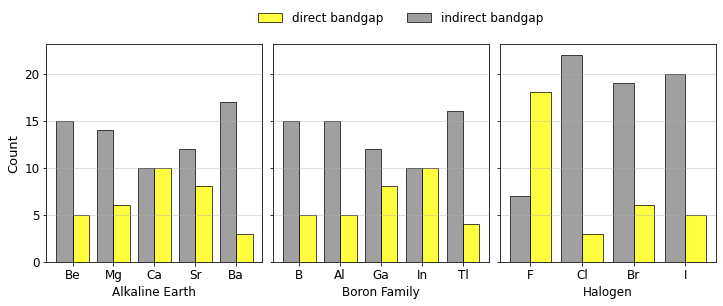

In [ ]:
dados2 = results_df.copy()

dados2['alkaline_earth'] =  pd.Categorical(dados2['A'], ['Be','Mg','Ca','Sr', 'Ba'])
dados2['boron_family'] =  pd.Categorical(dados2['B'], ['B','Al','Ga','In', 'Tl'])
dados2['halogen'] =  pd.Categorical(dados2['C'], ['F','Cl','Br','I'])

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sns.histplot(x="alkaline_earth",hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[0],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="boron_family", hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[1],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

sns.histplot(x="halogen", hue="bandgap_direct",
            palette=["grey", "yellow"], linewidth=0.7, ax=axes[2],
            data=dados2, multiple="dodge", shrink=.8, legend=None
           )

axes[0].grid(axis='y', alpha=0.5)
axes[1].grid(axis='y', alpha=0.5)
axes[2].grid(axis='y', alpha=0.5)

axes[0].set_xlabel('Alkaline Earth',  fontsize=12)
axes[1].set_xlabel('Boron Family',  fontsize=12)
axes[2].set_xlabel('Halogen',  fontsize=12)

axes[0].set_ylabel('Count',  fontsize=13)

axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='minor', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[2].tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(wspace=0.05)
plt.legend(labels = ['direct bandgap', 'indirect bandgap'],
           bbox_to_anchor =(0.25, 1.20),
           frameon=False, labelspacing=1, fontsize=12, ncol=2)

Por fim vamos fazer um **heatmap** com o bandgap para cada combinação de elemento químico:

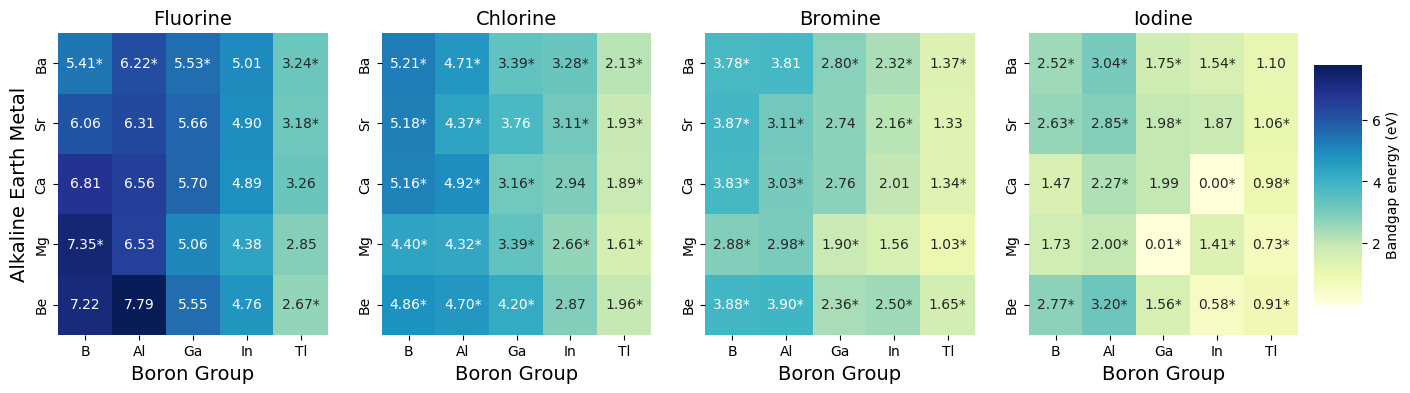

In [ ]:
# Heatmap Bandgap
escalax = ['Be','Mg','Ca','Sr','Ba']
escalay = ['B','Al','Ga','In','Tl']

heatmap_fenergy_F   = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_Cl  = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_Br  = np.zeros((len(escalay),len(escalax)))
heatmap_fenergy_I   = np.zeros((len(escalay),len(escalax)))

heatmap_direct_F = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_Cl = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_Br = np.zeros((len(escalay),len(escalax)), dtype=object)
heatmap_direct_I = np.zeros((len(escalay),len(escalax)), dtype=object)

    
for i in range(0, len(escalax)):
    for j in range(0, len(escalay)):
        dfx = results_df[results_df['A']==escalax[i]]
        dfy = dfx[dfx['B']==escalay[j]]
        
        heatmap_fenergy_F[i][j] = dfy[dfy['C']=='F']['bandgap'].values[0]
        heatmap_fenergy_Cl[i][j] = dfy[dfy['C']=='Cl']['bandgap'].values[0]
        heatmap_fenergy_Br[i][j] = dfy[dfy['C']=='Br']['bandgap'].values[0]
        heatmap_fenergy_I[i][j] = dfy[dfy['C']=='I']['bandgap'].values[0]
        
        if not(dfy[dfy['C']=='F']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='F']['bandgap'].values[0] == 0:
                heatmap_direct_F[i][j] = ''
            else:
                heatmap_direct_F[i][j] = '*'
        else:
            heatmap_direct_F[i][j] = ''
            
        if not(dfy[dfy['C']=='Cl']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='Cl']['bandgap'].values[0] == 0:
                heatmap_direct_Cl[i][j] = ''
            else:
                heatmap_direct_Cl[i][j] = '*'
        else:
            heatmap_direct_Cl[i][j] = ''
            
        if not(dfy[dfy['C']=='Br']['bandgap_direct'].values[0]):
            if dfy[dfy['C']=='Br']['bandgap'].values[0] == 0:
                heatmap_direct_Br[i][j] = ''
            else:
                heatmap_direct_Br[i][j] = '*'
        else:
            heatmap_direct_Br[i][j] = ''
            
        if not(dfy[dfy['C']=='I']['bandgap_direct'].values[0]): 
            if dfy[dfy['C']=='I']['bandgap'].values[0] == 0:
                heatmap_direct_I[i][j] = ''
            else:
                heatmap_direct_I[i][j] = '*'
        else:
            heatmap_direct_I[i][j] = ''

            
nomes = ['Fluorine', 'Chlorine', 'Bromine', 'Iodine']
matrizes = [heatmap_fenergy_F, heatmap_fenergy_Cl, heatmap_fenergy_Br, heatmap_fenergy_I]
directs = [heatmap_direct_F, heatmap_direct_Cl, heatmap_direct_Br, heatmap_direct_I]

maior=[]
menor=[]
for mat in matrizes:
    maior.append(np.amax(mat))
    menor.append(np.amin(mat))
    
vmin = min(menor)
vmax = max(maior)

fig, ax = plt.subplots(1,4, figsize=(16,4), dpi=100)
cbar_ax = fig.add_axes([.91,.2,.03,.6])

for i, axis in enumerate(ax):
    
    labels = (np.asarray(["{1:.2f}{0}".format(string, value)
                      for string, value in zip(directs[i].flatten(),
                                               matrizes[i].flatten())])
         ).reshape(len(escalax), len(escalay))
    
    sns.heatmap(matrizes[i], annot=labels, fmt="", 
                linewidths=0.0, ax=axis,
                xticklabels=escalay, yticklabels=escalax,
                cbar=True,
                vmin=vmin,
                vmax=vmax,
                cmap="YlGnBu", #BuPu
                robust=False,
                cbar_ax = cbar_ax,
                cbar_kws={'label': 'Bandgap energy (eV)'})
    axis.invert_yaxis()
    if i==0:
        axis.set_ylabel('Alkaline Earth Metal', fontsize=14)
    axis.set_xlabel('Boron Group', fontsize=14)
    axis.set_title(nomes[i], fontsize=14)

plt.rcParams['font.size'] = 12
#plt.savefig('bandgap1.png')